## 0. Introduction

This file contains the description and the code of an analysis around the current most dominant topic of the world: The Corona crisis. It was developed as part of the Udacity education program "Data Scientist". 

**Disclaimer: The entire project and all analysis results MUST NOT be considered as scientifically proven insights about the Corona epidemic. It is a project of an inexperienced student in Data Science and its primary purpose is to 
a) finalize the Udacity Data Science training program, and 
b) to generate some insights about the potential of publicly available data in a world-wide crisis.**

The analysis does follow the "Cross-industry standard process for data mining", in short CRISP-DM process model. Thus the first two chapter of the notebook do contain a summary of "Business Understanding" and "Data Understanding". The further steps of the CRISP-DM model are integrated into each of the 5 questions (see chapter below.)

## 1. Business Understanding

Over the first few month in 2020, the Covid-19/Corona virus pandemic has put the entire world into a serious health, social and economic crisis. The pandemic has spread rapidly, and is still spreading rapidly, across all countries. Most countries have closed their borders and shut down their normal societal and economic life.

The Corona pandemic is omnipresent all over the world and many people are working hard to better understand 

1. how quickly the virus spreads across countries and societies,
2. what measures might have an impact on the infection and/or death growth rate,
3. and what the major implications of the virus pandemic will be. 

The insights resulting from such analysis could then be used by politicians to take decisions on if and how to either loosen or intensify societal and economical restrictions.

The analysis in this project focusses on the following questions:

1. Which sources of trustful data around the Corona pandemic exists?
2. What kind of data is provided in the various sources and how can it be used to help understand, how fast the virus spreads per country?
3. Are there significant differences between countries in how the pandemic develops? And what might be the reasons for these differences?
4. How do the number of Corona infections and Corona deaths correlate with each other? Are there significant differences between countries?
5. How can the implications of the Corona pandemic be measures by data?

## 2. Data Understanding

The first major challenge of such a project is to identify appropriate and trustworthy data sources. 

After investigation of various publically available sources, I have selected the "European Centre for Disease Prevention and Control" (ECDC) as data provider. The agency provides downloadable data files, which are updated daily and contain the latest available public data on COVID-19.

A detailed discussion of potential data sources is included in the COVID-19 data exploration blog.

### Import libraries and gain some first insights about the provided data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display
from sklearn import preprocessing


The ECDC dataset can be downloaded as CSV file. For this project the data from the 29th of April has been used and stored in the subfolder "data". From there it can be read via the standard Pandas function read_csv.

In [2]:
# Read the ECDC dataset into a Pandas data frame
filename = "data/ECDC_COVID19_20200429.csv"

df_cases = pd.read_csv(filename)

# Show some more information about the data 
df_cases.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,28/04/2020,28,4,2020,172,0,Afghanistan,AF,AFG,37172386.0,Asia
1,27/04/2020,27,4,2020,68,10,Afghanistan,AF,AFG,37172386.0,Asia
2,26/04/2020,26,4,2020,112,4,Afghanistan,AF,AFG,37172386.0,Asia
3,25/04/2020,25,4,2020,70,1,Afghanistan,AF,AFG,37172386.0,Asia
4,24/04/2020,24,4,2020,105,2,Afghanistan,AF,AFG,37172386.0,Asia


The ECDC dataset contains 11 columns:

+ dateRep: Reporting day inlcuding year and month
+ day: Reporting day
+ month: Reporting month
+ year: Reporing year
+ cases: Number of new infections over the last 24h
+ death: Number of new deaths over the last 24h
+ countriesAndTerritories: Name of the country or territory which reported the number
+ geoId: ID of the reporting country
+ countryterritoryCode: Official country code of the reporting country
+ popData2018: Size of the population of the reporting country
+ continentExp: Continent of the reporting country

## Data Preprocessing
### Check the data types and convert as appropriate

In [3]:
# Check imported data types
print("Data Types before conversion:")
print(df_cases.dtypes)

df_cases.dateRep = pd.to_datetime(df_cases.dateRep, format='%d/%m/%Y')


print("\nData Types after conversion:")
print(df_cases.dtypes)

Data Types before conversion:
dateRep                     object
day                          int64
month                        int64
year                         int64
cases                        int64
deaths                       int64
countriesAndTerritories     object
geoId                       object
countryterritoryCode        object
popData2018                float64
continentExp                object
dtype: object

Data Types after conversion:
dateRep                    datetime64[ns]
day                                 int64
month                               int64
year                                int64
cases                               int64
deaths                              int64
countriesAndTerritories            object
geoId                              object
countryterritoryCode               object
popData2018                       float64
continentExp                       object
dtype: object


### Some statistics to verify the data further.

In [4]:
# Number of rows
print("Overall number of rows in the data set: {}\n\n".format(df_cases.shape[0]))

# What are the first and latest reporint days?
print("First reporting day in the data set: {}".format(min(df_cases['dateRep'])))
print("Latest reporting day in the data set: {}\n\n".format(max(df_cases['dateRep'])))

# Number of current total infections and total death?
print("Number of current total infections: {}".format(sum(df_cases['cases'])))
print("Number of current total deaths: {}\n\n".format(sum(df_cases['deaths'])))

# Number of unique countries or territories
print("Number of unique countries or territories within the data set: {}\n\n".format(df_cases.countriesAndTerritories.nunique()))

# Are there any NaN values in the data set?
print("Number of NaN values per column in the data set: {}\n\n".format(df_cases.isna().sum()))


Overall number of rows in the data set: 13623


First reporting day in the data set: 2019-12-31 00:00:00
Latest reporting day in the data set: 2020-04-28 00:00:00


Number of current total infections: 2982688
Number of current total deaths: 210193


Number of unique countries or territories within the data set: 207


Number of NaN values per column in the data set: dateRep                      0
day                          0
month                        0
year                         0
cases                        0
deaths                       0
countriesAndTerritories      0
geoId                       45
countryterritoryCode       152
popData2018                126
continentExp                 0
dtype: int64




Some rows have no geoID, CountryterritoryCode or popData2018. Lets analyse these rows in more detail and adjust as appropriate.

In [5]:
# Show countries and their number of cases / deaths, which do not have a geoID
countries = df_cases[df_cases["geoId"].isnull()]["countriesAndTerritories"].unique()
print("Countries with missing geoId:")
for country in countries:
    print("\t{} with {} cases and {} deaths.".format(country, df_cases[df_cases["countriesAndTerritories"]==country]["cases"].sum(), df_cases[df_cases["countriesAndTerritories"]==country]["deaths"].sum()))

# Show countries and their number of cases / deaths, which do not have a countryterritoryCode
countries = df_cases[df_cases["countryterritoryCode"].isnull()]["countriesAndTerritories"].unique()
print("\nCountries with missing countryterritoryCode:")
for country in countries:
    print("\t{} with {} cases and {} deaths.".format(country, df_cases[df_cases["countriesAndTerritories"]==country]["cases"].sum(), df_cases[df_cases["countriesAndTerritories"]==country]["deaths"].sum()))

# Show countries and their number of cases / deaths, which do not have popData2018
countries = df_cases[df_cases["popData2018"].isnull()]["countriesAndTerritories"].unique()
print("\nCountries with missing popData2018:")
for country in countries:
    print("\t{} with {} cases and {} deaths.".format(country, df_cases[df_cases["countriesAndTerritories"]==country]["cases"].sum(), df_cases[df_cases["countriesAndTerritories"]==country]["deaths"].sum()))

Countries with missing geoId:
	Namibia with 16 cases and 0 deaths.

Countries with missing countryterritoryCode:
	Anguilla with 3 cases and 0 deaths.
	Bonaire, Saint Eustatius and Saba with 6 cases and 0 deaths.
	Cases_on_an_international_conveyance_Japan with 696 cases and 7 deaths.
	Falkland_Islands_(Malvinas) with 13 cases and 0 deaths.
	Western_Sahara with 6 cases and 0 deaths.

Countries with missing popData2018:
	Anguilla with 3 cases and 0 deaths.
	Bonaire, Saint Eustatius and Saba with 6 cases and 0 deaths.
	Eritrea with 39 cases and 0 deaths.
	Falkland_Islands_(Malvinas) with 13 cases and 0 deaths.
	Western_Sahara with 6 cases and 0 deaths.


In [6]:
# Re-sort the data frame along the reporting data
df_cases.sort_values(by=["countriesAndTerritories", "dateRep"],inplace=True)


### Data Understanding Results

Overall, the ECDC dataset contains very "clean" and comprehensive data. More than 200 countries are included with a total of 2 982 688 infections and 210 193 deaths (as of April 28th). There are just a few NaN values, and all of them will most likely not have any major impact on the further analysis.

Therefore we will continue the project based on the selected data set. No further general data preprocessing steps are required.

## Q1: How fast does the pandamic develop within a specific country?

After having identified a trustful data source for the development of infections and deaths, let's see how this data can be used to help understand, how fast the virus spreads in a specific country. For this analysis I have selected Germany as country to be analysed. However, all steps of this analysis can be re-iterated in the same way for any other country.

### Data Preparation & Modeling for Q1

The following KPIs shall be evaluated to determine which KPI, or which combination of KPI's is the best one to answer this question:
+ "Growth Rate": Percentage growth of infections / deaths
  + Calcuated as {number of new cases on day x} / {cumulated number of cases up to day x} * 100
+ "Doubling Days": Number of days in which the number of cases doubles
  + Calculated as {cumulated cases up to day x} / {average number of cases over the last 5 days}
+ "Change of Growth Rate": Change rate of the "Growth Rate"
  + Calculated as {average growth rate of (day x-5 up to day x)} / {average growth rate of (day x-6 up to day x-1)}

In [7]:
# Step 1: Create a subset of the overall data frame that only contains data from the country to be analysed
country_scope = "Germany"
day_of_first_infection = df_cases[df_cases["countriesAndTerritories"]==country_scope]["dateRep"].min()
day_of_first_infection = df_cases[(df_cases["countriesAndTerritories"]==country_scope) & (df_cases["cases"]>0)]["dateRep"].min()
df_country = df_cases[(df_cases["countriesAndTerritories"]==country_scope) & (df_cases["dateRep"]>=day_of_first_infection)].reset_index()
# df_country.set_index("dateRep", inplace=True)

In [8]:
# Day with the highest number of deaths per day
df_country[df_country["deaths"] == df_country["deaths"].max()]

,index,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
79,4861,2020-04-16,16,4,2020,2866,315,Germany,DE,DEU,82927922.0,Europe


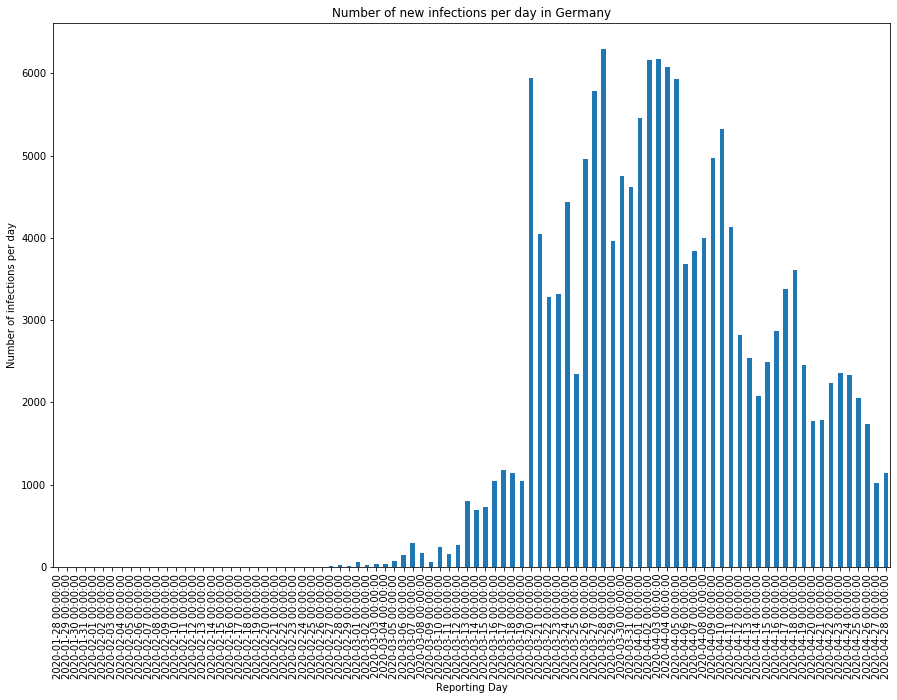

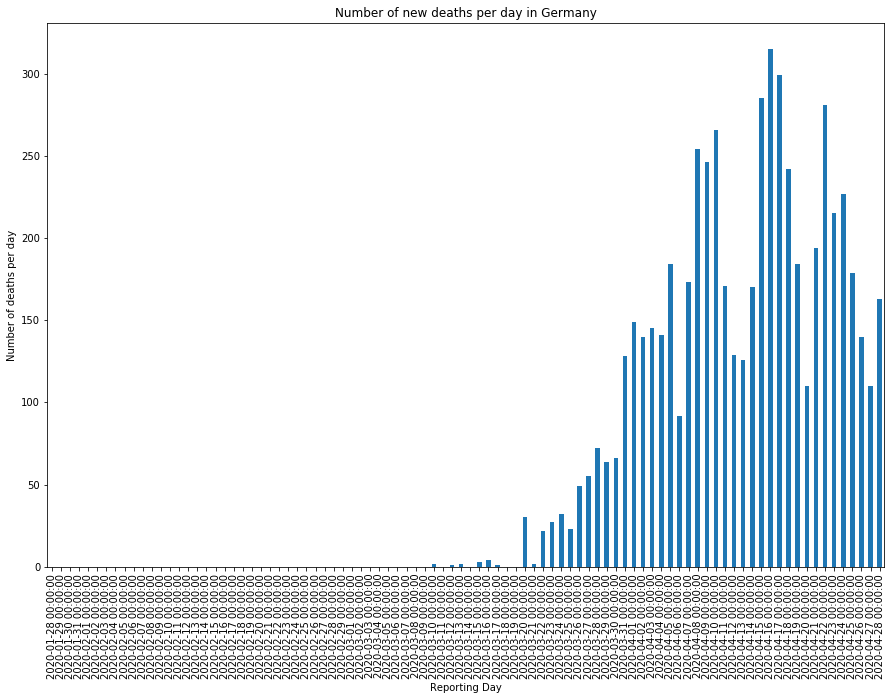

In [48]:
# Step 2: Visualize number of infections and deaths per day

plt.figure(figsize=(15,10))
df_country.set_index("dateRep")["cases"].plot.bar(title="Number of new infections per day in " + country_scope)
plt.rcParams["figure.figsize"] = (15, 10)
plt.xlabel('Reporting Day')
plt.ylabel('Number of infections per day')
plt.show()


plt.rcParams["figure.figsize"] = (15, 10)
df_country.set_index("dateRep")["deaths"].plot.bar(title="Number of new deaths per day in " + country_scope)
plt.xlabel('Reporting Day')
plt.ylabel('Number of deaths per day')
plt.show()

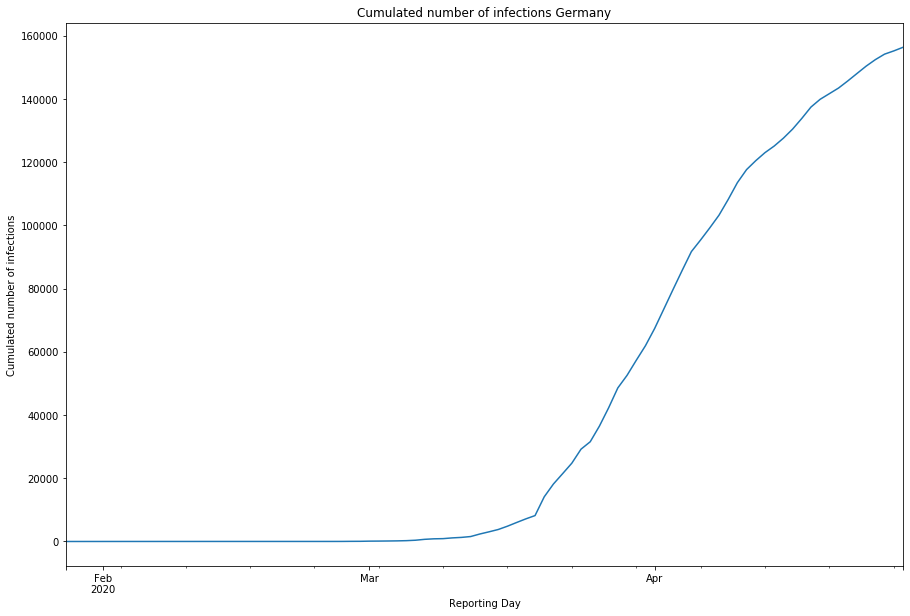

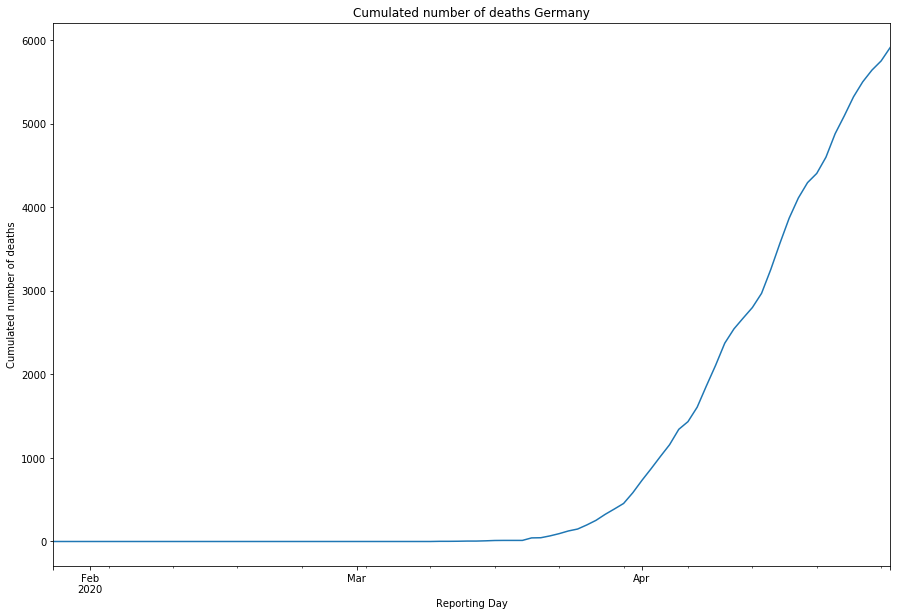

In [49]:
# Step 3: Visualize cumulated number of infections and deaths

# Calculate cumulated sums
df_country[["cum_cases", "cum_deaths"]] = df_country[["cases", "deaths"]].cumsum()

plt.rcParams["figure.figsize"] = (15, 10)
df_country.set_index("dateRep")["cum_cases"].plot.line(title="Cumulated number of infections " + country_scope)
plt.xlabel('Reporting Day')
plt.ylabel('Cumulated number of infections')
plt.show()


plt.rcParams["figure.figsize"] = (15, 10)
df_country.set_index("dateRep")["cum_deaths"].plot.line(title="Cumulated number of deaths " + country_scope)
plt.xlabel('Reporting Day')
plt.ylabel('Cumulated number of deaths')
plt.show()

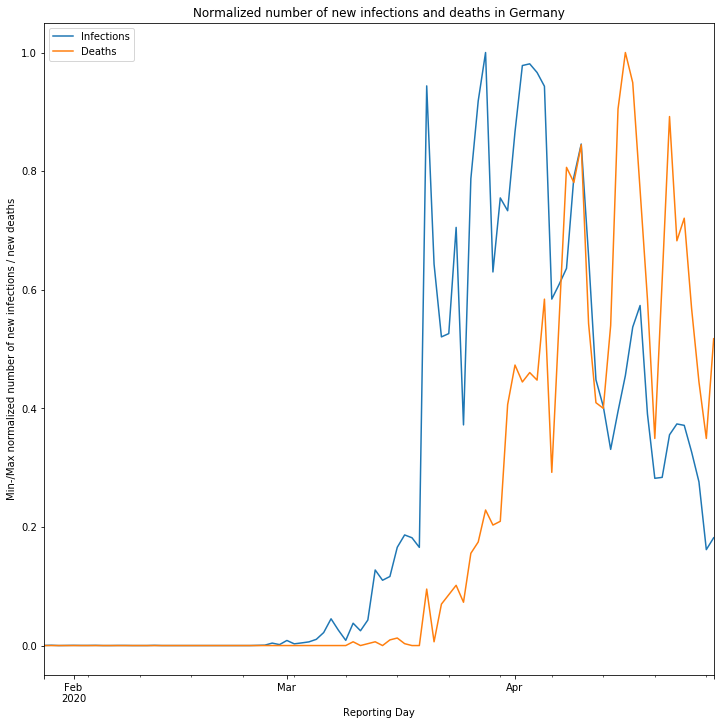

In [56]:
# Step 4: Normalize the numbers of new infections and days and visualize them in one chart

# Normalize the number of infections and the number of deaths using sklearn's preprocessing capabilities
min_max_scaler = preprocessing.MinMaxScaler()
df_country["cases_norm"] = min_max_scaler.fit_transform(df_country["cases"].to_numpy().reshape(-1, 1))
df_country["deaths_norm"] = min_max_scaler.fit_transform(df_country["deaths"].to_numpy().reshape(-1, 1))

# Plot the normalized numbers
plt.rcParams["figure.figsize"] = (12, 12)
df_country.set_index("dateRep")[["cases_norm", "deaths_norm"]].plot.line(title="Normalized number of new infections and deaths in " + country_scope)
plt.xlabel('Reporting Day')
plt.ylabel('Min-/Max normalized number of new infections / new deaths')
plt.legend(["Infections", "Deaths"])
plt.show()


### 4. Growth rate an doubling time of new infections / new deahts


Growth rate and "Doubling Time" of new infections are further key measure to assess the speed of a pandemic spread. The formulas are

#### Growth rate
p = (TodayCumulatedNumber - YesterdayCumulatedNumber) / YesterdayCumulatedNumber

 <=> p = DailyNewCases / YesterdayCumulatedNumber

 <=> p = DailyNewCases / (TodayCumulatedNumber - DailyNewCases)

#### Doubling Time
t = Ln(2) / Ln(1+p)

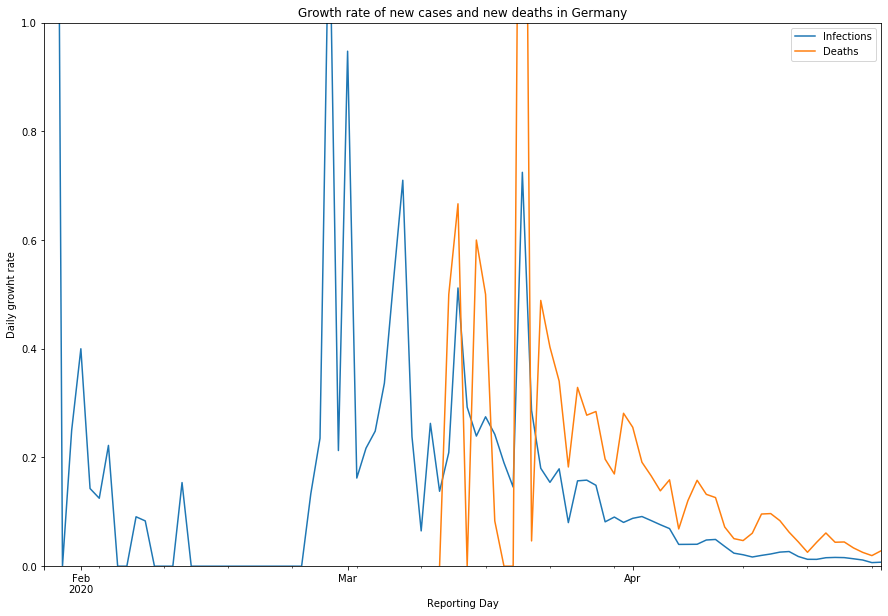

In [68]:
# Step 4.1 Create columns growth_rate_cases and growth_rate_deaths
df_country["growth_rate_cases"] = df_country["cases"] / (df_country["cum_cases"] - df_country["cases"])
df_country["growth_rate_deaths"] = df_country["deaths"] / (df_country["cum_deaths"] - df_country["deaths"])

# Plot the growth rates
plt.rcParams["figure.figsize"] = (15, 10)
df_country.set_index("dateRep")[["growth_rate_cases", "growth_rate_deaths"]].plot.line(title="Growth rate of new cases and new deaths in " + country_scope, ylim=(0,1))
plt.xlabel('Reporting Day')
plt.ylabel('Daily growht rate')
plt.legend(["Infections", "Deaths"])
plt.show()

The growth rate of infections does nicely illustrate the exponential growth around end of February until mid of March. In this time frame we can see significant daily growth rates. From mid of March onwards, the growth rate for new infections has flattened significantly.

The growth rate of deaths does follow the growth rate of new infections with around 2 weeks delay.

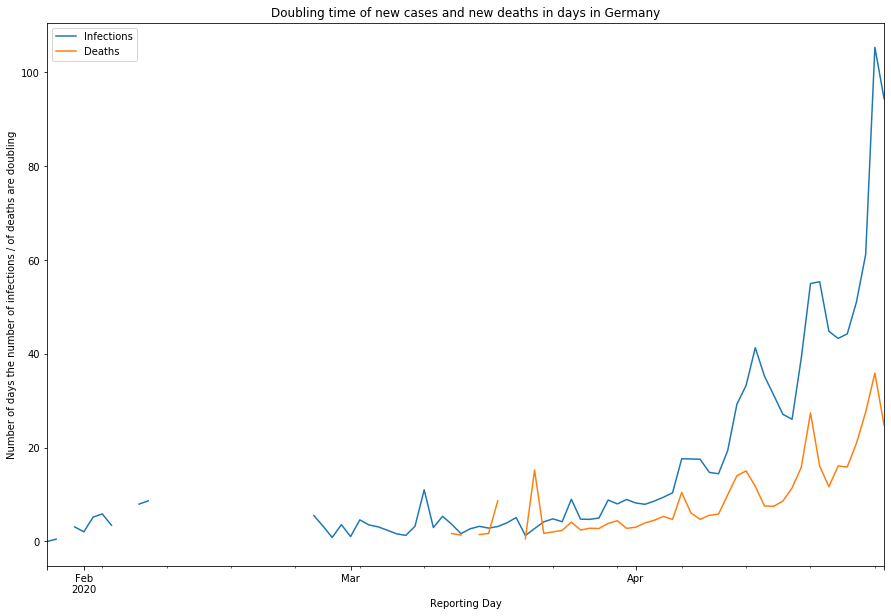

In [66]:
# Step 4.2 Create columns doubling_time_cases and doubling_time_deaths
df_country["doubling_time_cases"] = np.log(2) / np.log(1+(df_country["growth_rate_cases"]))
df_country["doubling_time_deaths"] = np.log(2) / np.log(1+(df_country["growth_rate_deaths"]))

# Plot the doubling times
plt.rcParams["figure.figsize"] = (15, 10)
df_country.set_index("dateRep")[["doubling_time_cases", "doubling_time_deaths"]].plot.line(title="Doubling time of new cases and new deaths in days in " + country_scope)
plt.xlabel('Reporting Day')
plt.ylabel('Number of days the number of infections / of deaths are doubling')
plt.legend(["Infections", "Deaths"])
plt.show()

The doubling time of new infections was surprisingly stable until mid to end of March. Just by end of March the doubling time started to increase more rapidly and is by now close to 100 days.

The doubling time of new deaths is again following the curve of new infections with around 2 weeks of delay. However, the increase is not yet that significantly.

### Conclusions
The main conclusions out of this second part of the project can be summarized as follows:
1. The publicly available data around the COVID-19 pandemic can be easily used to understand the general dynamics of the pandemic in a single country.
2. At least for Germany, all KPI's from the above sub-chapters indicate that the pandemic development up to know can be structured into 4 phases:
   + *P1 - Warming Up:* The number of new infections per day is at a very low level and stable (4-5 weeks).
   + *P2 - Explosion:* The number of new infections is growing significantly, somehow exploding (1-2 weeks).
   + *P3 - Hot:* The number of new infections varies per day, but seems to be stable overall at a quite high level (3 weeks).
   + *P4 - Cool Down:* The number of new infections declines slowly (x weeks).
3. While all of the KPIs used in this chapter do provide their specific insights, a combination of all does provide the highest value.

## Part III: Analysis of differences in the development of the pandemic between countries
### Intro and Motivation
The COVID-19 pandemic is a world-wide occurrence. And countries are following very different approaches to save lives and not overwhelm healthcare systems. How do these different approach affect the development of the pandemic?


While we have focused on Germany in part II of the project, it makes sense to compare the development of the pandemic between countries in order to 
+ Assess success or failure of the different strategies to cope with the pandemic
+ Identify significant differences as indicator for a root cause analysis
+ Identify common patterns which could help to create more certainty around assumptions about the further development of the pandemic in a specific country.
** Approach
For this analysis we will focus on the following countries:
1. Germany, as we have analyzed Germany already in the chapter before. Germany has reacted quickly to the pandemic, but the measures have not been as restrictive as in Italy or Spain.
2. Italy, as Italy was the first country in Europe with extremely high number of infections and deaths. Italy has reacted not as quickly after the pandemic started in the country, but than put quite restrictive measures in place.
3. USA, as the US is the country with the by far highest number of infections and deaths. The US also reacted rahther late than quickly to the pandemic. The current measure are very different between the various US states.
4. Sweden, as Sweden has taken a very different approach to COVID-19, with significant less restrictive measures than in other countries.
5. UK, as the UK had started with a less restricted approach and then turned to a very rigid approach to tackle COVID-19.

For these 5 countries we will calculate and compare the following KPIs:
+ Development of new infections/deaths in relation to their population size
+ Development of infections/deaths as a percentage of their population size
+ Growth rates and doubling time of new infections/deaths

### KPI 1: Development of new infections/deaths in relation to their population size
#### Purpose and Expectations
This KPI should help us to verify, whether the pandemic develops similar in different countries or whether there are some differences. Based on the observations from part II of this project, in which we have analyzed the development of the pandemic in Germany, and the above briefly outlined different approaches, we could assume:
1. A faster and more significant increase in new cases through the "explosion" phase in Italy, the US and the UK compared to Germany.
2. As the measures in the UK and Italy are more restrict compared to Germany, we could assume that the decrease of new infections/deaths is steeper in those countries.
3. As Sweden is still sticking to the more relaxed approach, I would assume that neither the "explosion" phase nor the "cool down" phase is as steep as in the other countries. This would however not explain, why the more relaxed approach is keeping Sweden in a sufficiently acceptable state with regard to COVID-19 infections and deaths.

#### Data Preparation

In [109]:
# Step 1: Create a subset of the overall data frame that only contains data from the countries to be analysed
country_scope = ["Germany", "Italy", "United_States_of_America", "Sweden", "United_Kingdom"]
df_countries = df_cases[df_cases["countriesAndTerritories"].isin(country_scope)].reset_index()

# Step 2 Create columns rel_cases and rel_deaths
df_countries["rel_cases"] = df_countries["cases"] / df_countries["popData2018"] * 100
df_countries["rel_deaths"] = df_countries["deaths"] / df_countries["popData2018"] * 100

# Step 3: Pivot the dataset for easier plotting
df_countries_piv_cases = pd.pivot_table(df_countries,index='dateRep',columns='countriesAndTerritories',values="rel_cases").reset_index()
df_countries_piv_deaths = pd.pivot_table(df_countries,index='dateRep',columns='countriesAndTerritories',values="rel_deaths").reset_index()

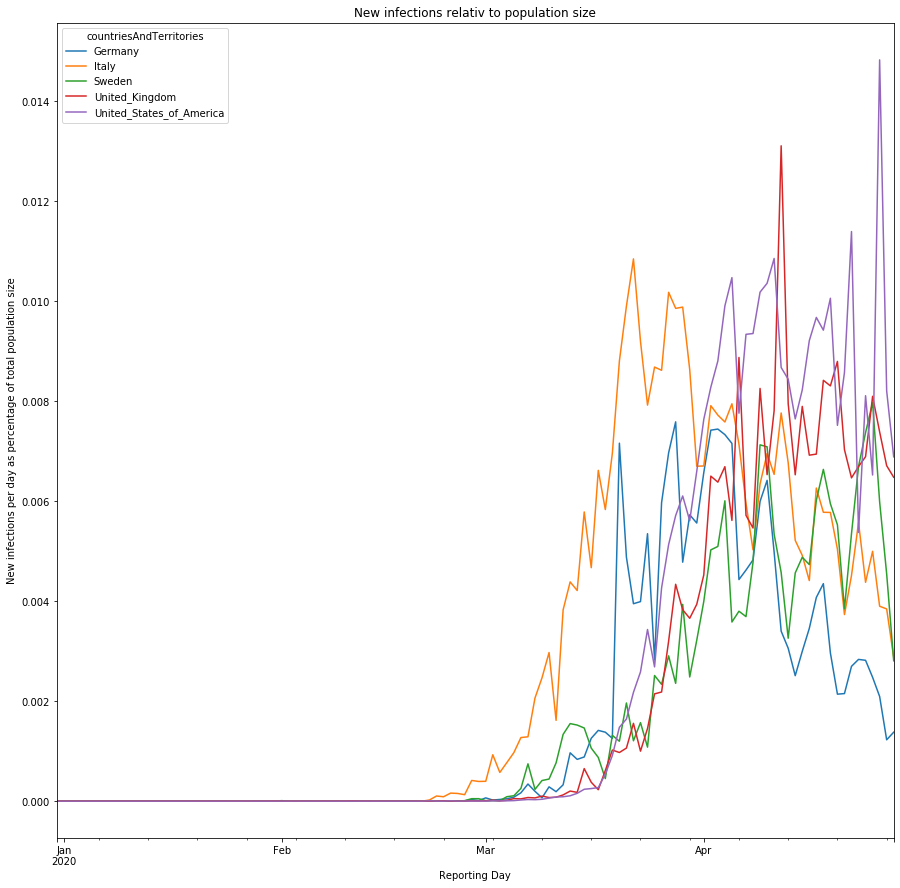

In [110]:
# Step 4: Plot the relativ number of infections from the five countries
plt.rcParams["figure.figsize"] = (15, 15)
df_countries_piv_cases.set_index("dateRep").plot.line(title="New infections relativ to population size")
plt.xlabel('Reporting Day')
plt.ylabel('New infections per day as percentage of total population size')
plt.show()

The graph above does show relevant numbers starting by mid of February. So we adjust the plot and start with Feb 15th.

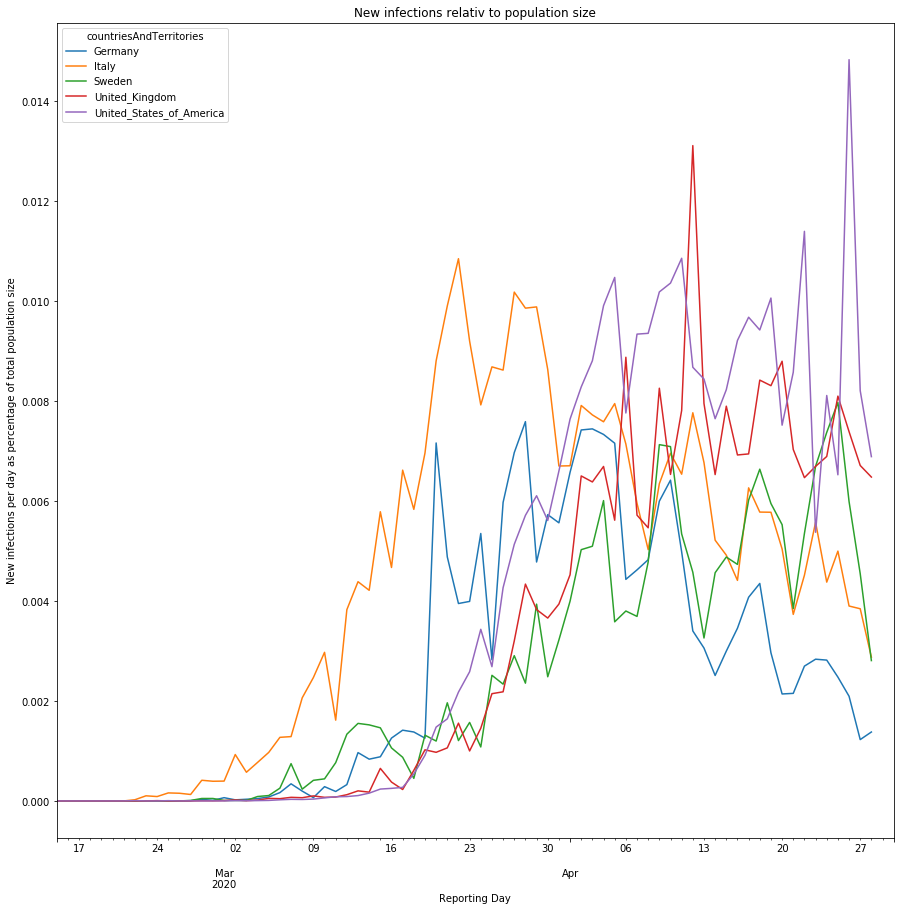

In [111]:
# Step 4.2: Plot the relativ number of infections from the five countries starting with Feb 15th
plt.rcParams["figure.figsize"] = (15, 15)
df_countries_piv_cases.set_index("dateRep").plot.line(title="New infections relativ to population size", xlim=("2020-02-15","2020-04-30"))
plt.xlabel('Reporting Day')
plt.ylabel('New infections per day as percentage of total population size')
plt.show()

In [ ]:
# Step 4.2: Plot the relativ number of deaths from the five countries starting with Feb 15th
plt.rcParams["figure.figsize"] = (15, 15)
df_countries_piv_deaths.set_index("dateRep").plot.line(title="New deaths relativ to population size", xlim=("2020-02-15","2020-04-30"))
plt.xlabel('Reporting Day')
plt.ylabel('New deaths per day as percentage of total population size')
plt.show()

In [ ]:
# Step 4: Normalize the numbers of new infections and days and visualize them in one chart

# Normalize the number of infections and the number of deaths using sklearn's preprocessing capabilities
min_max_scaler = preprocessing.MinMaxScaler()
df_country["cases_norm"] = min_max_scaler.fit_transform(df_country["cases"].to_numpy().reshape(-1, 1))
df_country["deaths_norm"] = min_max_scaler.fit_transform(df_country["deaths"].to_numpy().reshape(-1, 1))

# Plot the normalized numbers
plt.rcParams["figure.figsize"] = (12, 12)
df_country.set_index("dateRep")[["cases_norm", "deaths_norm"]].plot.line(title="Normalized number of new infections and deaths in " + country_scope)
plt.xlabel('Reporting Day')
plt.ylabel('Min-/Max normalized number of new infections / new deaths')
plt.legend(["Infections", "Deaths"])
plt.show()


#### Create two new columns with cumlated cases and deaths

In [18]:
# Step 0: Create a deep copy of the data set to be ready to start from here again
df_cum = df_cases.copy().reset_index()

# Step 1: Make sure the data is properly sorted by country and date
df_cum = df_cum.sort_values(['countriesAndTerritories','dateRep']).reset_index()

# Step 2: Calcluate two additional columns with cumulative cases and deaths
df_cum["cum_cases"] = df_cum.groupby(['countriesAndTerritories', 'dateRep'])["cases", "deaths"].sum().groupby(level=0).cumsum().reset_index()[["cases", "deaths"]]["cases"]
df_cum["cum_deaths"] = df_cum.groupby(['countriesAndTerritories', 'dateRep'])["cases", "deaths"].sum().groupby(level=0).cumsum().reset_index()[["cases", "deaths"]]["deaths"]

# Step 3: Get rid of additional columns created in the steps before
df_cum = df_cum[["dateRep", "day", "month", "year", "cases", "deaths", "countriesAndTerritories", "geoId", "countryterritoryCode", "popData2018", "cum_cases", "cum_deaths"]]

NameError: name 'df_cases' is not defined

#### Create columns growth_rate_cases and growth_rate_deaths

The formula to be used is {number of new cases on day x} / {cumulated number of cases up to day x} * 100

In [19]:
# Step 0: Create a deep copy of the data set to be ready to start from here again
df_cum_gr = df_cum.copy()

# Step 1: Calculate two new columns based on the formula {number of new cases on day x} / {cumulated number of cases up to day x} * 100
df_cum_gr["growth_rate_cases"] = df_cum[df_cum["cum_cases"]>1]["cases"] / df_cum[df_cum["cum_cases"]>=1]["cum_cases"] * 100
df_cum_gr["growth_rate_deaths"] = df_cum[df_cum["cum_deaths"]>1]["deaths"] / df_cum[df_cum["cum_deaths"]>=1]["cum_deaths"] * 100

NameError: name 'df_cum' is not defined

#### Create columns double_days_cases and double_days_deaths

The formula to be used is {cumulated cases up to day x} / {average number of cases over the last 5 days}. For each country we first calculate the rolling cumulated cases / deaths per 5 days. Then we apply the before mentioned function.

In [20]:
# Step 1: Get the list of countries
countries = list(df_cum_gr.countriesAndTerritories.unique())

# Step 2: Create the target data frame with two additional columns to hold the rolling cumulated cases per 5 days
new_cols = list(df_cum_gr.columns)
new_cols.extend(["rol_cases","rol_deaths"])
df_cum_gr_d = pd.DataFrame(columns=new_cols)

# Step 3: For each country calculate the rolling average of cases and death over the last 5 days
for country in countries:
    df = df_cum_gr[df_cum_gr["countriesAndTerritories"] == country].copy()
    df["rol_cases"] = df["cases"].rolling(min_periods=1, window=5).sum() / 5
    df["rol_deaths"] = df["deaths"].rolling(min_periods=1, window=5).sum() / 5
    df_cum_gr_d = pd.concat([df_cum_gr_d, df])

# Step 4: Calculate the final figures
df_cum_gr_d["rol_cases"].replace(0, np.nan, inplace=True) # to avoid division by zero errors
df_cum_gr_d["rol_deaths"].replace(0, np.nan, inplace=True) # to avoid division by zero errors
df_cum_gr_d["double_days_cases"] = df_cum_gr_d["cum_cases"] / df_cum_gr_d["rol_cases"]
df_cum_gr_d["double_days_deaths"] = df_cum_gr_d["cum_deaths"] / df_cum_gr_d["rol_deaths"]

NameError: name 'df_cum_gr' is not defined

#### Create columns change_growth_rate_cases and change_growth_rate_death

The formula to be used is {average growth rate of (day x-5 up to day x)} / {average growth rate of (day x-6 up to day x-1)}. Again, we need to calculate these numbers per country.

In [21]:
# Convert some object dtypes to numeric dtypes
df_expanded["cum_cases"] = pd.to_numeric(df_expanded["cum_cases"], errors = "coerce")
df_expanded["cum_deaths"] = pd.to_numeric(df_expanded["cum_deaths"], errors = "coerce")
df_expanded["double_days_cases"] = pd.to_numeric(df_expanded["double_days_cases"], errors = "coerce")
df_expanded["double_days_deaths"] = pd.to_numeric(df_expanded["double_days_deaths"], errors = "coerce")

NameError: name 'pd' is not defined

In [22]:
# Step 1: Get the list of countries
countries = list(df_cum_gr_d.countriesAndTerritories.unique())

# Step 2: Create the target data frame with two additional columns to hold the rolling cumulated cases per 5 days
new_cols = list(df_cum_gr_d.columns)
new_cols.extend(["change_growth_rate_cases","change_growth_rate_deaths"])
df_expanded = pd.DataFrame(columns=new_cols)


# Step 3: For each country calculate the rolling average of growth_rate (for cases and for deaths) over the last 5 days
for country in countries:
    df = df_cum_gr_d[df_cum_gr_d["countriesAndTerritories"] == country].copy()
    df["rol_growth_rate_cases"] = df["growth_rate_cases"].rolling(min_periods=1, window=5).sum() / 5
    df["rol_growth_rate_deaths"] = df["growth_rate_deaths"].rolling(min_periods=1, window=5).sum() / 5
    df["change_growth_rate_cases"] = df["rol_growth_rate_cases"].pct_change()
    df["change_growth_rate_deaths"] = df["rol_growth_rate_deaths"].pct_change()
    df_expanded = pd.concat([df, df_expanded], sort=False)



NameError: name 'df_cum_gr_d' is not defined

In [23]:
df_expanded.columns

NameError: name 'df_expanded' is not defined

### Evaluation of the proposed KPI's to understand how fast the virus spreads within a country

In the previous chapter three KPI's have been prepared for a better understanding on how fast the virus spreads within a country. In this chapter we will visualize these KPI's and compare them with each other.

We will conduct our analysis for the following 5 countries: Germany, Italy, UK, USA, Sweden

In [24]:

focus_countries = ["Germany", "Italy", "United_States_of_America", "United_Kingdom"]
focus_countries = ["Germany"]
focus_values = ["cum_cases", "growth_rate_cases"]
df_exp_piv = pd.pivot_table(df_expanded,index='dateRep',columns='countriesAndTerritories',values=focus_values).reset_index()
ax = plt.gca()
df_exp_piv.plot(kind='line',x='dateRep',y='Germany',ax=ax)
plt.show()

NameError: name 'pd' is not defined

In [25]:
df_exp_piv

NameError: name 'df_exp_piv' is not defined

In [26]:
with pd.option_context("display.max_rows", df_expanded.shape[0]):
    display(df_expanded[df_expanded["geoId"]=="DE"])

NameError: name 'pd' is not defined

In [28]:
df_expanded.head()

NameError: name 'df_expanded' is not defined

## 3. General Data Preparation

ECDC's data files contain the number of newly reported cases and deaths per day. As we want to analyse the growth rate per country, we will convert the data into two cumlated and pivoted tables. One with with cumlative cases and one with cumlated deaths.

### Create two new columns with cumlated cases and deaths

In [30]:
# Step 1: Make sure the data is properly sorted by country and date
df_sorted = df_cases.sort_values(['countriesAndTerritories','dateRep'])

# Step 2: Calcluate two additional columns with cumulative cases and deaths
df_cum = df_sorted.copy().reset_index()

df_cum["cum_cases"] = df_cum.groupby(['countriesAndTerritories', 'dateRep'])["cases"].sum().groupby(level=0).cumsum().reset_index()["cases"]

df_cum["cum_deaths"] = df_cum.groupby(['countriesAndTerritories', 'dateRep'])["deaths"].sum().groupby(level=0).cumsum().reset_index()["deaths"]

NameError: name 'df_cases' is not defined

### Create two new data-frames with pivoted data on the cumulated numbers

In [31]:
df_cases_piv = pd.pivot_table(df_cum,index='dateRep',columns='countriesAndTerritories',values='cum_cases').reset_index()
df_deaths_piv = pd.pivot_table(df_cum,index='dateRep',columns='countriesAndTerritories',values='cum_deaths').reset_index()

NameError: name 'df_cum' is not defined

In [32]:
df_cases_piv

NameError: name 'df_cases_piv' is not defined

In [33]:
# gca stands for 'get current axis'
ax = plt.gca()

df_cases_piv.plot(kind='line',x='dateRep',y='Germany',ax=ax)
df_deaths_piv.plot(kind='line',x='dateRep',y='Germany',ax=ax)


plt.show()

NameError: name 'df_cases_piv' is not defined

#### Data Preparation Next Steps

Further data adjustments are needed to answer the above stated questions of interest. These further data preparation activities will be performed "by question" to make it easier for the reader to follow the origianl train of thoughts. 

## 4. Data Understanding, Preparation, Modeling, Evaluation and Development by Question

The further steps of the CRISP-DM model are integrated into each of the 4 questions (see chapter Business Understanding)